In [1]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
# given the shapes.txt file in the urban folder, print the map of the urban stops
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

import os

In [2]:
BASE_URI_METRO = "GTFS_DATA/True_Metro/"
BASE_URI_URBAN = "GTFS_DATA/True_Urbanos/"
BASE_URI_INTERURBAN = "GTFS_DATA/True_Interurbanos/google_transit_M89/"
BASE_URI_CERCANIAS = "GTFS_DATA/True_Cercanias/"

## GENERATE NODES AND EGDES 

In [21]:
def process_edges(stop_times_file,stops_file, output_file, stats_output_file):
    metro_stop_times = pd.read_csv(stop_times_file)
    metro_stops = pd.read_csv(stops_file)
    df = metro_stop_times.merge(metro_stops[['stop_id','stop_name']], on='stop_id')
    # Read the original CSV file
    
    df_sorted = df.sort_values(by=['trip_id', 'stop_sequence'])
    
    # Create a new column with the next stop_id
    # Using shift with a negative value to get the "next" row's value

    df_sorted['next_stop_id'] = df_sorted.groupby('trip_id')['stop_id'].shift(-1)
    df_sorted['next_stop_name'] = df_sorted.groupby('trip_id')['stop_name'].shift(-1)
    df_sorted['next_stop_sequence'] = df_sorted.groupby('trip_id')['stop_sequence'].shift(-1)
    df_sorted['next_arrival_time'] = df_sorted.groupby('trip_id')['arrival_time'].shift(-1)

    df_sorted[df_sorted['stop_sequence'] + 1 == df_sorted['next_stop_sequence']]

    # if next_arrival_time[:2] >= 24, change to 00. same with departure_time
    df_sorted.loc[df_sorted['next_arrival_time'].str[:2] >= '24', 'next_arrival_time'] = '00' + df_sorted['next_arrival_time'].str[2:]
    df_sorted.loc[df_sorted['departure_time'].str[:2] >= '24', 'departure_time'] = '00' + df_sorted['departure_time'].str[2:]
    
    df_sorted['time_diff'] = (pd.to_datetime(df_sorted['next_arrival_time'],format='%H:%M:%S') - pd.to_datetime(df_sorted['departure_time'],format='%H:%M:%S')).dt.total_seconds()
    # for those time_diff < 0, add 24 hours
    df_sorted.loc[df_sorted['time_diff'] < 0, 'time_diff'] += 24 * 60 * 60    

    df_sorted = df_sorted[['trip_id', 'stop_id', 'stop_name', 'stop_sequence', 'departure_time', 'next_stop_id', 'next_stop_name', 'next_stop_sequence', 'next_arrival_time', 'time_diff']]
    # the length of the trip is given by the number of stops or the biggest stop_sequence
    df_sorted['trip_length'] = df_sorted.groupby('trip_id')['stop_sequence'].transform('max')
    df_sorted['trip_length'] = df_sorted['trip_length'].astype(int) + 1
    
    df_sorted.to_csv(output_file, index=False)



    df_sorted = df_sorted.dropna()
    df_sorted['stop1'] = df_sorted[['stop_name', 'next_stop_name']].min(axis=1)
    df_sorted['stop2'] = df_sorted[['stop_name', 'next_stop_name']].max(axis=1)

    stats_df = df_sorted.groupby(['stop1', 'stop2']).aggregate({
        'time_diff': 'mean',
    }).reset_index()
    stats_df.columns = ['stop1', 'stop2', 'mean_time_diff']
    stats_df.to_csv(stats_output_file, index=False)


    return     df_sorted,stats_df
    # remove rows where nex

# stop_times[[trip_id,name]] es las lineas 'par' de stops.txt join con stop_times original

def process_nodes(stops_file, output_file):
    metro_stops = pd.read_csv(stops_file)
    metro_stops = metro_stops.drop_duplicates(subset='stop_id')
    metro_stops = metro_stops[metro_stops['location_type'] == 0]
    metro_stops = metro_stops[['stop_id', 'stop_name', 'stop_lat', 'stop_lon']]
    metro_stops.to_csv(output_file, index=False)
    return metro_stops

#### PROCESS METRO NODES AND EDGES

In [204]:
stop_times_file = BASE_URI_METRO + "stop_times.txt"  # Input file path
stop_file = BASE_URI_METRO + "stops.txt"  # Input file path
edge_file = BASE_URI_METRO + "_edges.csv"  # Output file path
stats_edge_file = BASE_URI_METRO + "_stats_edges.csv"  # Output file path
node_file = BASE_URI_METRO + "_nodes.csv"  # Output file path

if not os.path.exists(edge_file) or not os.path.exists(stats_edge_file) or not os.path.exists(node_file):
    metro_edges, metro_edge_stats = process_edges(stop_times_file, stop_file, edge_file, stats_edge_file)
    metro_nodes = process_nodes(stop_file, node_file)
else:
    metro_edges = pd.read_csv(edge_file)
    metro_edge_stats = pd.read_csv(stats_edge_file)
    metro_nodes = pd.read_csv(node_file)

### PROCESS URBAN BUS NODES AND EDGES

In [205]:

urban_stop_times_file = BASE_URI_URBAN + "stop_times.txt"  # Input file path
urban_stop_file = BASE_URI_URBAN + "stops.txt"  # Input file path
urban_edge_file = BASE_URI_URBAN + "_edges.csv"  # Output file path
urban_stats_edge_file = BASE_URI_URBAN + "_stats_edges.csv"  # Output file path
urban_node_file = BASE_URI_URBAN + "_nodes.csv"  # Output file path


if not os.path.exists(urban_edge_file) or not os.path.exists(urban_stats_edge_file) or not os.path.exists(urban_node_file):
    urban_edges, urban_edge_stats = process_edges(urban_stop_times_file, urban_stop_file, urban_edge_file, urban_stats_edge_file)
    urban_nodes = process_nodes(urban_stop_file, urban_node_file)
else:
    urban_edges = pd.read_csv(urban_edge_file)
    urban_edge_stats = pd.read_csv(urban_stats_edge_file)
    urban_nodes = pd.read_csv(urban_node_file)


### PROCESS INTERURBAN BUS NODES AND EDGES

In [ ]:


if not os.path.exists(BASE_URI_CERCANIAS + "_edges.csv") or not os.path.exists(BASE_URI_CERCANIAS + "_stats_edges.csv") or not os.path.exists(BASE_URI_CERCANIAS + "_nodes.csv"):

    for folder in os.listdir(BASE_URI_INTERURBAN):
        # if folder is zip, continue
        if folder.endswith('.zip') or folder.endswith('.txt'):
            continue
        stop_times_file = BASE_URI_INTERURBAN + folder + "/stop_times.txt"  # Input file path
        stop_file = BASE_URI_INTERURBAN + folder + "/stops.txt"  # Input file path
        edge_file = BASE_URI_INTERURBAN + folder + "/_edges.csv"  # Output file path
        stats_edge_file = BASE_URI_INTERURBAN + folder + "/_stats_edges.csv"  # Output file path
        node_file = BASE_URI_INTERURBAN + folder + "/_nodes.csv"  # Output file path


        result, stats = process_edges(stop_times_file, stop_file, edge_file, stats_edge_file)
        nodes = process_nodes(stop_file, node_file)

    edges = []
    nodes = []
    edge_stats = []

    for folder in os.listdir(BASE_URI_INTERURBAN):
        if folder.endswith('.zip') or folder.endswith('.txt'):
            continue
        edge_file = BASE_URI_INTERURBAN + folder + "/_edges.csv"  # Output file path
        stats_edge_file = BASE_URI_INTERURBAN + folder + "/_stats_edges.csv"  # Output file path
        node_file = BASE_URI_INTERURBAN + folder + "/_nodes.csv"  # Output file path

        edges.append(pd.read_csv(edge_file))
        edge_stats.append(pd.read_csv(stats_edge_file))
        nodes.append(pd.read_csv(node_file))
    
    inter_edges = pd.concat(edges)
    inter_edge_stats = pd.concat(edge_stats)
    inter_nodes = pd.concat(nodes)

    inter_edges.to_csv(BASE_URI_INTERURBAN + "_edges.csv", index=False)
    inter_edge_stats.to_csv(BASE_URI_INTERURBAN + "_stats_edges.csv", index=False)
    inter_nodes.to_csv(BASE_URI_INTERURBAN + "_nodes.csv", index=False)
else:
    inter_edges = pd.read_csv(BASE_URI_INTERURBAN + "_edges.csv")
    inter_edge_stats = pd.read_csv(BASE_URI_INTERURBAN + "_stats_edges.csv")
    inter_nodes = pd.read_csv(BASE_URI_INTERURBAN + "_nodes.csv")


paradas mergeadas con sus nombres
dataframe shifteado
dataframe almacenado en csv
paradas mergeadas con sus nombres
dataframe shifteado
dataframe almacenado en csv
paradas mergeadas con sus nombres
dataframe shifteado
dataframe almacenado en csv
paradas mergeadas con sus nombres
dataframe shifteado
dataframe almacenado en csv
paradas mergeadas con sus nombres
dataframe shifteado
dataframe almacenado en csv
paradas mergeadas con sus nombres
dataframe shifteado
dataframe almacenado en csv
paradas mergeadas con sus nombres
dataframe shifteado
dataframe almacenado en csv
paradas mergeadas con sus nombres
dataframe shifteado
dataframe almacenado en csv
paradas mergeadas con sus nombres
dataframe shifteado
dataframe almacenado en csv
paradas mergeadas con sus nombres
dataframe shifteado
dataframe almacenado en csv
paradas mergeadas con sus nombres
dataframe shifteado
dataframe almacenado en csv
paradas mergeadas con sus nombres
dataframe shifteado
dataframe almacenado en csv
paradas mergeada

### PROCESS CERCANIAS NODES AND EDGES

In [207]:
cercanias_stop_times_file = BASE_URI_CERCANIAS + "stop_times.txt"  # Input file path
cercanias_stop_file = BASE_URI_CERCANIAS + "stops.txt"  # Input file path
cercanias_edge_file = BASE_URI_CERCANIAS + "_edges.csv"  # Output file path
cercanias_stats_edge_file = BASE_URI_CERCANIAS + "_stats_edges.csv"  # Output file path
cercanias_node_file = BASE_URI_CERCANIAS + "_nodes.csv"  # Output file path

if not os.path.exists(cercanias_edge_file) or not os.path.exists(cercanias_stats_edge_file) or not os.path.exists(cercanias_node_file):
    cercanias_edges, cercanias_edge_stats = process_edges(cercanias_stop_times_file, cercanias_stop_file, cercanias_edge_file, cercanias_stats_edge_file)
    cercanias_nodes = process_nodes(cercanias_stop_file, cercanias_node_file)
else:
    cercanias_edges = pd.read_csv(cercanias_edge_file)
    cercanias_edge_stats = pd.read_csv(cercanias_stats_edge_file)
    cercanias_nodes = pd.read_csv(cercanias_node_file)

# EMBED BUS NODES INTO METRO NODES

#### GET DISTANCE RELATION BETWEEN A ROW AND THE METRO NODES

In [ ]:
metro_nodes = pd.read_csv(BASE_URI_METRO + "_nodes.csv")
def get_closest_metro_stop(row):
    min_distance = np.inf
    closest_stop = None
    metro_lat = None
    metro_lon = None
    for i, metro_stop in metro_nodes.iterrows():
        distance = geodesic((row['stop_lat'], row['stop_lon']), (metro_stop['stop_lat'], metro_stop['stop_lon'])).meters
        if distance < min_distance:
            min_distance = distance
            closest_stop = metro_stop['stop_name']
            metro_lat = metro_stop['stop_lat']
            metro_lon = metro_stop['stop_lon']
    return closest_stop, min_distance, metro_lat, metro_lon



#### If no nodes are removed, the map of Madrid with the following

In [13]:
def nodes_to_gdf(nodes):
    gdf =  gpd.GeoDataFrame(
        nodes, geometry=gpd.points_from_xy(nodes.stop_lon, nodes.stop_lat), crs="EPSG:4326"
    )
    gdf = gdf.to_crs("EPSG:25830")
    return gdf

madrid_shp = gpd.read_file("MadridSHP/Barrios.shp")

In [4]:
urban_nodes = pd.read_csv(BASE_URI_URBAN + "_nodes.csv")
inter_nodes = pd.read_csv(BASE_URI_INTERURBAN + "_nodes.csv")
cercanias_nodes = pd.read_csv(BASE_URI_CERCANIAS + "_nodes.csv")

metro_nodes = pd.read_csv(BASE_URI_METRO + "_nodes.csv")

print("total urban nodes", len(urban_nodes))
print("total interurban nodes", len(inter_nodes))
print("total cercanias nodes", len(cercanias_nodes))

total urban nodes 4803
total interurban nodes 9897
total cercanias nodes 89


In [6]:
urban_nodes['transporte'] = 'urban'
inter_nodes['transporte'] = 'interurban'
metro_nodes['transporte'] = 'metro'

<Axes: >

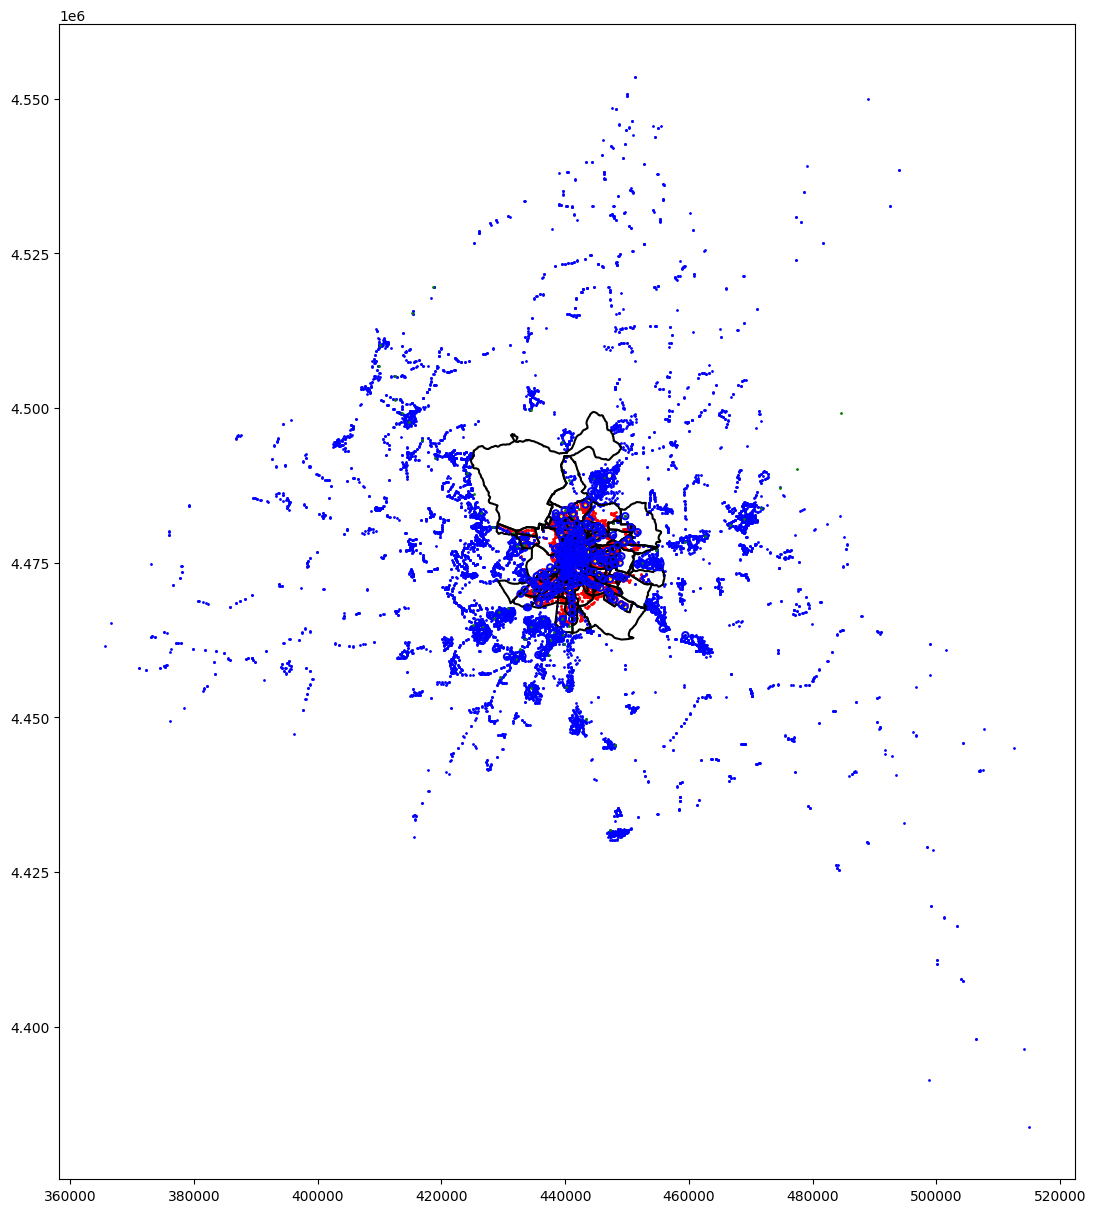

In [222]:
urban_shapes = nodes_to_gdf(urban_nodes)
inter_shapes = nodes_to_gdf(inter_nodes)
cercanias_shapes = nodes_to_gdf(cercanias_nodes)
metro_shapes = nodes_to_gdf(metro_nodes)

# hollow circles with 500m radius
metro_circles = metro_shapes.copy()
metro_circles['geometry'] = metro_circles.to_crs("EPSG:25830").buffer(500)

metro_circles = metro_shapes.copy()
metro_circles['geometry'] = metro_circles.to_crs("EPSG:25830").buffer(500)


fig, ax = plt.subplots(figsize=(15, 15))
madrid_shp.boundary.plot(ax=ax, color='black')
urban_shapes.plot(ax=ax, color='red', markersize=1)
metro_shapes.plot(ax=ax, color='yellow', markersize=1)
inter_shapes.plot(ax=ax, color='blue', markersize=1)
cercanias_shapes.plot(ax=ax, color='green', markersize=1)
metro_circles.boundary.plot(ax=ax, color='blue')


#### As we want to use Metro stops as the most important layer, we are going to remove urban bus stops, interurban bus stops and cercanias stops that are far away from metro stops

In [223]:
if os.path.exists(BASE_URI_URBAN + "_metro_distance_nodes.csv"):
    urban_nodes_metro_distance = pd.read_csv(BASE_URI_URBAN + "_metro_distance_nodes.csv")
else:
    urban_metro_stops = urban_nodes.apply(get_closest_metro_stop, axis=1, result_type='expand')
    urban_nodes_metro_distance = urban_nodes.copy()
    urban_nodes_metro_distance[['closest_metro_stop', 'distance_to_metro', 'metro_lat', 'metro_lon']] = urban_metro_stops
    urban_nodes_metro_distance.to_csv(BASE_URI_URBAN + "_metro_distance_nodes.csv", index=False)

if os.path.exists(BASE_URI_INTERURBAN + "_metro_distance_nodes.csv"):
    inter_nodes_metro_distance = pd.read_csv(BASE_URI_INTERURBAN + "_metro_distance_nodes.csv")
else:
    inter_metro_stops = inter_nodes.apply(get_closest_metro_stop, axis=1, result_type='expand')
    inter_nodes_metro_distance = inter_nodes.copy()
    inter_nodes_metro_distance[['closest_metro_stop', 'distance_to_metro', 'metro_lat', 'metro_lon']] = inter_metro_stops
    inter_nodes_metro_distance.to_csv(BASE_URI_INTERURBAN + "_metro_distance_nodes.csv", index=False)

if os.path.exists(BASE_URI_CERCANIAS + "_metro_distance_nodes.csv"):
    cercanias_nodes_metro_distance = pd.read_csv(BASE_URI_CERCANIAS + "_metro_distance_nodes.csv")
else:
    cercanias_metro_stops = cercanias_nodes.apply(get_closest_metro_stop, axis=1, result_type='expand')
    cercanias_nodes_metro_distance = cercanias_nodes.copy()
    cercanias_nodes_metro_distance[['closest_metro_stop', 'distance_to_metro', 'metro_lat', 'metro_lon']] = cercanias_metro_stops
    cercanias_nodes_metro_distance.to_csv(BASE_URI_CERCANIAS + "_metro_distance_nodes.csv", index=False)

metro_nodes = pd.read_csv(BASE_URI_METRO + "_nodes.csv")

In [224]:
DISTANCE_TO_METRO_THRESHOLD = 600 
urban_nodes_close_to_metro = urban_nodes_metro_distance[urban_nodes_metro_distance['distance_to_metro'] < DISTANCE_TO_METRO_THRESHOLD]
inter_nodes_close_to_metro = inter_nodes_metro_distance[inter_nodes_metro_distance['distance_to_metro'] < DISTANCE_TO_METRO_THRESHOLD]
cercanias_nodes_close_to_metro = cercanias_nodes_metro_distance[cercanias_nodes_metro_distance['distance_to_metro'] < DISTANCE_TO_METRO_THRESHOLD]

urban_nodes_close_to_metro.to_csv(BASE_URI_URBAN + "_nodes_close_to_metro.csv", index=False)
inter_nodes_close_to_metro.to_csv(BASE_URI_INTERURBAN + "_nodes_close_to_metro.csv", index=False)
cercanias_nodes_close_to_metro.to_csv(BASE_URI_CERCANIAS + "_nodes_close_to_metro.csv", index=False)

print("Urban nodes close to metro: ", len(urban_nodes_close_to_metro))
print("Interurban nodes close to metro: ", len(inter_nodes_close_to_metro))
print("Cercanias nodes close to metro: ", len(cercanias_nodes_close_to_metro))

Urban nodes close to metro:  3275
Interurban nodes close to metro:  1551
Cercanias nodes close to metro:  28


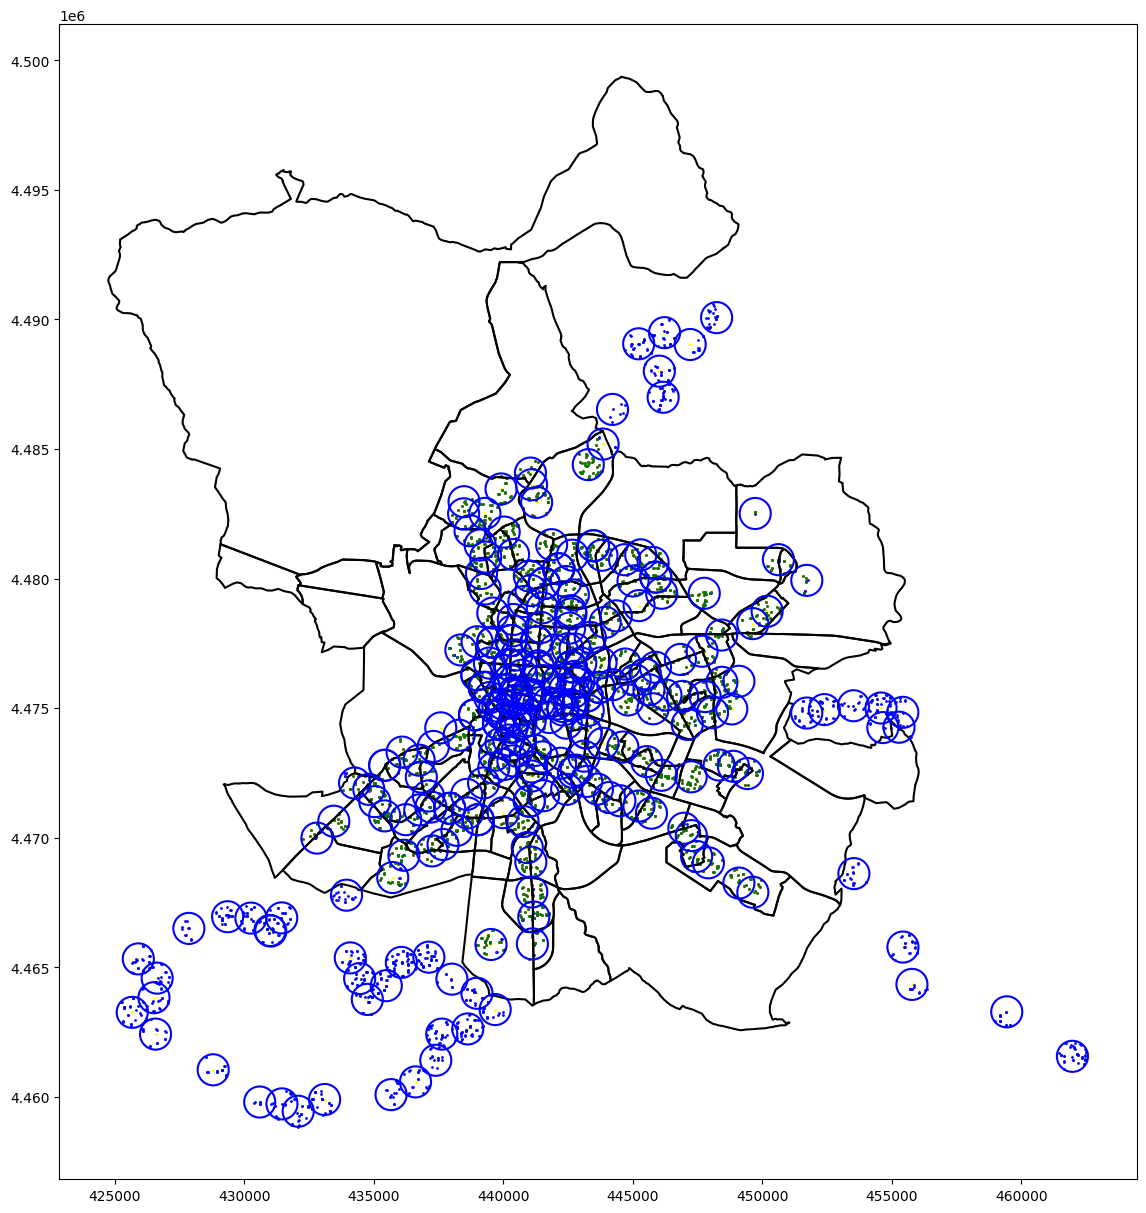

In [225]:
madrid_shp = gpd.read_file("MadridSHP/Barrios.shp")

urban_shapes = nodes_to_gdf(urban_nodes_close_to_metro)
inter_shapes = nodes_to_gdf(inter_nodes_close_to_metro)
cercanias_shapes = nodes_to_gdf(urban_nodes_close_to_metro)

metro_nodes = pd.read_csv(BASE_URI_METRO + "_nodes.csv")
metro_shapes = nodes_to_gdf(metro_nodes)

circle = metro_shapes.copy()
circle['geometry'] = circle.to_crs("EPSG:25830").buffer(DISTANCE_TO_METRO_THRESHOLD)

fig, ax = plt.subplots(figsize=(15, 15))
madrid_shp.boundary.plot(ax=ax, color='black')
urban_shapes.plot(ax=ax, color='red', markersize=1)
metro_shapes.plot(ax=ax, color='yellow', markersize=1)
inter_shapes.plot(ax=ax, color='blue', markersize=1)
cercanias_shapes.plot(ax=ax, color='green', markersize=1)
circle.boundary.plot(ax=ax, color='blue')
plt.show()


In [226]:
madrid_shp

,Shape_Leng,Shape_Area,CODDIS,COD_DIS_TX,NOMDIS,COD_BAR,COD_DISBAR,COD_DISB,NUM_BAR,NOMBRE,BARRIO_MAY,BARRIO_MT,FCH_ALTA,FCH_BAJA,OBSERVACIO,APROBACION,geometry
0,5754.828568,1.469906e+06,1,01,Centro,011,11,1-1,1,Palacio,PALACIO,PALACIO,0000/00/00,0000/00/00,None,None,"POLYGON ((440112.785 4474645.921, 440078.075 4..."
1,4275.226840,1.033724e+06,1,01,Centro,012,12,1-2,2,Embajadores,EMBAJADORES,EMBAJADORES,0000/00/00,0000/00/00,None,None,"POLYGON ((440277.382 4473980.839, 440368.002 4..."
2,3731.081359,5.918742e+05,1,01,Centro,013,13,1-3,3,Cortes,CORTES,CORTES,0000/00/00,0000/00/00,None,None,"POLYGON ((440780.52 4474528.375, 440907.759 44..."
3,3597.421057,7.394135e+05,1,01,Centro,014,14,1-4,4,Justicia,JUSTICIA,JUSTICIA,0000/00/00,0000/00/00,None,None,"POLYGON ((440991.949 4474492.423, 440907.759 4..."
4,4060.075563,9.480264e+05,1,01,Centro,015,15,1-5,5,Universidad,UNIVERSIDAD,UNIVERSIDAD,0000/00/00,0000/00/00,None,None,"POLYGON ((440517.952 4474758.368, 440476.812 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,6601.764852,2.031267e+06,21,21,Barajas,211,211,21-1,1,Alameda de Osuna,ALAMEDA DE OSUNA,ALAMEDA DE OSUNA,0000/00/00,0000/00/00,None,None,"POLYGON ((450614.387 4479399.407, 450752.655 4..."
127,28381.693927,2.966473e+07,21,21,Barajas,212,212,21-2,2,Aeropuerto,AEROPUERTO,AEROPUERTO,0000/00/00,0000/00/00,None,None,"POLYGON ((451940.168 4484759.459, 452134.178 4..."
128,3388.646303,5.493940e+05,21,21,Barajas,213,213,21-3,3,Casco Histórico de Barajas,CASCO HISTORICO DE BARAJAS,CASCO HISTÓRICO DE BARAJAS,0000/00/00,0000/00/00,None,None,"POLYGON ((451288.265 4480266.282, 451233.112 4..."
129,10723.320808,4.798439e+06,21,21,Barajas,214,214,21-4,4,Timón,TIMON,TIMÓN,0000/00/00,0000/00/00,None,None,"POLYGON ((450698.531 4479953.328, 450639.81 44..."


In [228]:
metro_shapes

,stop_id,stop_name,stop_lat,stop_lon,geometry
0,par_4_1,PLAZA DE CASTILLA,40.46690,-3.68917,POINT (441575.052 4479808.7)
1,par_4_10,TRIBUNAL,40.42619,-3.70110,POINT (440527.795 4475297.848)
2,par_4_11,GRAN VIA,40.42001,-3.70180,POINT (440462.967 4474612.341)
3,par_4_12,SOL,40.41688,-3.70326,POINT (440336.342 4474265.897)
4,par_4_13,TIRSO DE MOLINA,40.41235,-3.70466,POINT (440213.557 4473764.015)
...,...,...,...,...,...
285,par_4_234,HOSPITAL SEVERO OCHOA,40.32177,-3.76797,POINT (434754.721 4463754.488)
286,par_4_235,LEGANES CENTRAL,40.32899,-3.77154,POINT (434458.401 4464558.532)
287,par_4_236,SAN NICASIO,40.33616,-3.77587,POINT (434097.544 4465357.604)
288,par_4_237,OPERA,40.41809,-3.70928,POINT (439826.687 4474404.289)


In [246]:
metro_shapes['BARRIO_MT'] = metro_shapes.geometry.apply(lambda x: madrid_shp[madrid_shp.geometry.contains(x)]['BARRIO_MAY'].values[0] if len(madrid_shp[madrid_shp.geometry.contains(x)]) > 0 else 'Outside')


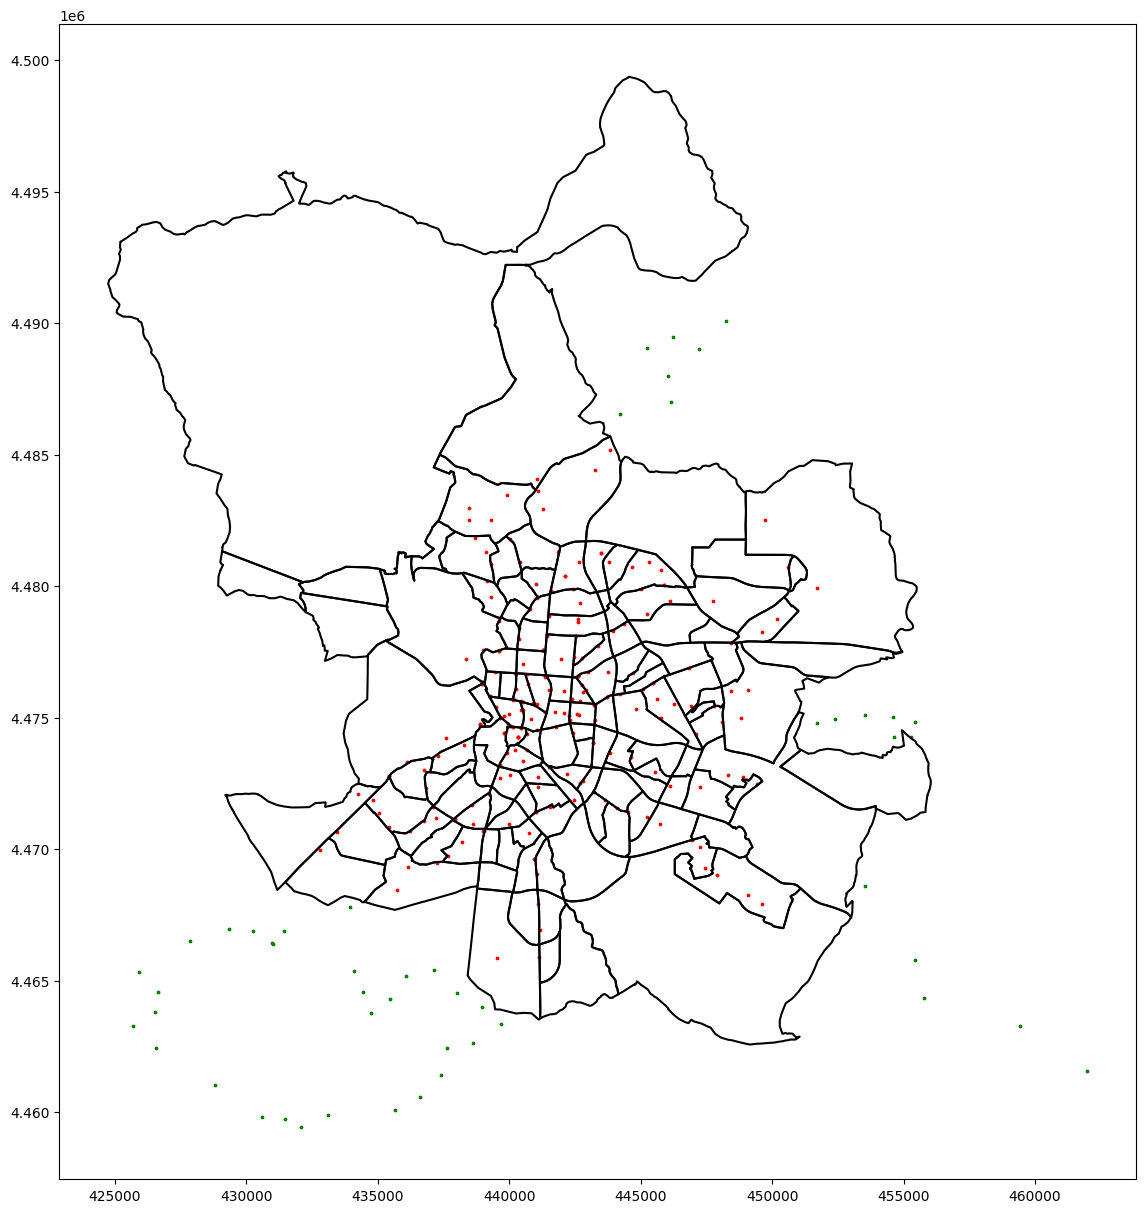

In [245]:
madrid_shp = gpd.read_file("MadridSHP/Barrios.shp")


circle = metro_shapes.copy()
circle['geometry'] = circle.to_crs("EPSG:25830").buffer(DISTANCE_TO_METRO_THRESHOLD)

fig, ax = plt.subplots(figsize=(15, 15))
madrid_shp.boundary.plot(ax=ax, color='black')
metro_shapes[metro_shapes['BARRIO_MT'] == 'Outside'].plot(ax=ax, color='green', markersize=3)
metro_shapes[metro_shapes['BARRIO_MT'] != 'Outside'].plot(ax=ax, color='red', markersize=3)
plt.show()

#### Now that we know which nodes are to be removed, we need to generate the new edges

In [5]:
# for folder in interurban_folders merge trips.txt and stop_times.txt
stop_times = []
trips = []

for folder in os.listdir(BASE_URI_INTERURBAN):
    if folder.endswith('.zip') or folder.endswith('.txt') or folder.endswith('.csv'):
        continue
    stop_times_file = BASE_URI_INTERURBAN + folder + "/stop_times.txt"  # Input file path
    trips_file = BASE_URI_INTERURBAN + folder + "/trips.txt"  # Input file path
    stop_times.append(pd.read_csv(stop_times_file))
    trips.append(pd.read_csv(trips_file))

stop_times = pd.concat(stop_times)
trips = pd.concat(trips)

stop_times.to_csv(BASE_URI_INTERURBAN + "stop_times.txt", index=False)
trips.to_csv(BASE_URI_INTERURBAN + "trips.txt", index=False)

In [9]:
# read all interesting files up to now
metro_edges = pd.read_csv(BASE_URI_METRO + "_edges.csv")
metro_edge_stats = pd.read_csv(BASE_URI_METRO + "_stats_edges.csv")
metro_nodes = pd.read_csv(BASE_URI_METRO + "_nodes.csv")

urban_edges = pd.read_csv(BASE_URI_URBAN + "_edges.csv")
urban_edge_stats = pd.read_csv(BASE_URI_URBAN + "_stats_edges.csv")
urban_nodes = pd.read_csv(BASE_URI_URBAN + "_nodes.csv")

inter_edges = pd.read_csv(BASE_URI_INTERURBAN + "_edges.csv")
inter_edge_stats = pd.read_csv(BASE_URI_INTERURBAN + "_stats_edges.csv")
inter_nodes = pd.read_csv(BASE_URI_INTERURBAN + "_nodes.csv")

urban_nodes_close_to_metro = pd.read_csv(BASE_URI_URBAN + "_nodes_close_to_metro.csv")
inter_nodes_close_to_metro = pd.read_csv(BASE_URI_INTERURBAN + "_nodes_close_to_metro.csv")

urban_trips = pd.read_csv(BASE_URI_URBAN + "trips.txt")
inter_trips = pd.read_csv(BASE_URI_INTERURBAN + "trips.txt")
metro_trips = pd.read_csv(BASE_URI_METRO + "trips.txt")


In [ ]:
metro_nodes
urban_nodes
inter_nodes

,stop_id,stop_name,stop_lat,stop_lon
0,par_4_1,PLAZA DE CASTILLA,40.46690,-3.68917
1,par_4_10,TRIBUNAL,40.42619,-3.70110
2,par_4_11,GRAN VIA,40.42001,-3.70180
3,par_4_12,SOL,40.41688,-3.70326
4,par_4_13,TIRSO DE MOLINA,40.41235,-3.70466
...,...,...,...,...
285,par_4_234,HOSPITAL SEVERO OCHOA,40.32177,-3.76797
286,par_4_235,LEGANES CENTRAL,40.32899,-3.77154
287,par_4_236,SAN NICASIO,40.33616,-3.77587
288,par_4_237,OPERA,40.41809,-3.70928


In [ ]:
# functions  to embed the edges into the metro graph

def remove_outside_edges(edges, embedding_nodes):
    # create a new column with the stop_id of the closest metro stop
    edges = edges.set_index(['trip_id', 'stop_id'])
    edges['is_in'] = edges.index.get_level_values('stop_id').isin(embedding_nodes['stop_id']).astype(int)
    edges['embedded_stop_sequence'] = edges['is_in'].groupby('trip_id').cumsum()

    embedded_edges = edges.reset_index().groupby(['trip_id', 'embedded_stop_sequence']).aggregate({
        'stop_id': 'first',
        'stop_name': 'first',
        'departure_time': 'first',
        'next_arrival_time': 'first',
        'time_diff': 'sum',
    })

    embedded_edges = embedded_edges.reset_index()
    embedded_edges['next_embedded_stop_id'] = embedded_edges.groupby('trip_id')['stop_id'].shift(-1)

    # if the first stop of a trip is far from the metro, the first embedded_stop_sequence is 0, so we need to remove it
    embedded_edges = embedded_edges[embedded_edges['embedded_stop_sequence'] > 0]

    embedded_edges['next_embedded_stop_id'] = embedded_edges['next_embedded_stop_id'].astype(str).str.replace('nan', '')
    

    return embedded_edges


def get_closest_inside_edges(edges, embedding_nodes):
    # create a new column with the stop_id of the closest metro stop

    edges = edges.set_index(['stop_id'])
    embedding_nodes = embedding_nodes.set_index(['stop_id'])
    

    # edges.loc[:,'closest_metro_stop'] = edges.loc[:,'stop_id'].map(embedding_nodes.set_index('stop_id').loc[:,'closest_metro_stop'])
    # edges.loc[:,'distance_to_metro'] = edges.loc[:,'stop_id'].map(embedding_nodes.set_index('stop_id').loc[:,'distance_to_metro'])

    edges = edges.join(embedding_nodes[['closest_metro_stop','distance_to_metro']], on='stop_id', rsuffix='_closest', how='inner')
    edges = edges.reset_index()

    edges.loc[:,'is_closest_metro'] = edges.groupby(['trip_id','closest_metro_stop'])['distance_to_metro'].transform(lambda x: x == x.min()).astype(int)
    edges.loc[:,'embedded_stop_sequence'] = edges.groupby(['trip_id'])['is_closest_metro'].cumsum()

    
    embedded_edges = edges.groupby(['trip_id','embedded_stop_sequence']).agg({
        'stop_name': 'first',
        'stop_id': 'first',
        'departure_time': 'first',
        'next_arrival_time': 'first',
        'time_diff': 'sum',
        'closest_metro_stop': 'first',
        'distance_to_metro': 'first',
    }).reset_index()
    
    embedded_edges['next_embedded_stop_id'] = embedded_edges.groupby('trip_id')['stop_id'].shift(-1)

    #if the first stop of a trip is not the closest metro stop, the embedded_stop_sequence is 0, so we need to remove it
    embedded_edges = embedded_edges[embedded_edges['embedded_stop_sequence'] > 0]
    embedded_edges['next_embedded_stop_id'] = embedded_edges['next_embedded_stop_id'].astype(str).str.replace('nan', '')
    embedded_edges['next_metro_stop'] = embedded_edges['next_embedded_stop_id'].map(embedding_nodes['closest_metro_stop'])


    return embedded_edges

In [204]:
print("The number of urban edges is: ", len(urban_edges))
print("The number of urban trips is: ", len(urban_edges['trip_id'].unique()))

embedded_urban_edges = remove_outside_edges(urban_edges,urban_nodes_close_to_metro)
embedded_urban_edges = get_closest_inside_edges(embedded_urban_edges,urban_nodes_close_to_metro)

print("The number of urban edges after the embedding: ", len(embedded_urban_edges))
print("The number of urban trips after the embedding: ", len(embedded_urban_edges['trip_id'].unique()))

# save the embedded edges to a new file
embedded_urban_edges.to_csv(BASE_URI_URBAN + "_embedded_edges.csv", index=False)



The number of urban edges is:  2692781
The number of urban trips is:  103742
The number of urban edges after the embedding:  840748
The number of urban trips after the embedding:  103478


In [161]:
print("The number of interurban edges is: ", len(inter_edges))
print("The number of interurban trips is: ", len(inter_edges['trip_id'].unique()))

embedded_inter_edges = remove_outside_edges(inter_edges, inter_nodes_close_to_metro)
embedded_inter_edges = get_closest_inside_edges(embedded_inter_edges, inter_nodes_close_to_metro)

print("The number of interurban edges after the embedding: ", len(embedded_inter_edges))
print("The number of interurban trips after the embedding: ", len(embedded_inter_edges['trip_id'].unique()))

embedded_inter_edges.to_csv(BASE_URI_INTERURBAN + "_embedded_edges.csv", index=False)

The number of interurban edges is:  1512834
The number of interurban trips is:  58765
The number of interurban edges after the embedding:  168434
The number of interurban trips after the embedding:  46673


In [ ]:
# function to aggregate the embedded edges into a new dataframe

def get_embedded_stats_edges(edges):

    # mean distance to closest metro stop
    df_aux = edges.groupby(['closest_metro_stop']).agg({
        'distance_to_metro': 'mean',
    }).reset_index()

    

    # drop next_metro_stop nan
    edges = edges.dropna(subset=['next_metro_stop'])

    
    
    edges.loc[:,'stop1'] = edges.loc[:,['closest_metro_stop', 'next_metro_stop']].min(axis=1)
    edges.loc[:,'stop2'] = edges.loc[:,['closest_metro_stop', 'next_metro_stop']].max(axis=1)



    grouped_edges = edges.groupby(['stop1', 'stop2']).agg({
        'time_diff': 'mean',
    }).reset_index()
    grouped_edges.columns = ['stop1', 'stop2', 'mean_time_diff']
    
    grouped_edges['distance_to_stop1'] = grouped_edges.join(df_aux.set_index('closest_metro_stop'), on='stop1', rsuffix='_closest')['distance_to_metro']
    grouped_edges['distance_to_stop2'] = grouped_edges.join(df_aux.set_index('closest_metro_stop'), on='stop2', rsuffix='_closest')['distance_to_metro']
    
    return grouped_edges

In [200]:
embedded_grouped_urban_edges = get_embedded_stats_edges(embedded_urban_edges)
embedded_grouped_urban_edges.to_csv(BASE_URI_URBAN + "_embedded_stats_edges.csv", index=False)
embedded_grouped_inter_edges = get_embedded_stats_edges(embedded_inter_edges)   
embedded_grouped_inter_edges.to_csv(BASE_URI_INTERURBAN + "_embedded_stats_edges.csv", index=False)

C:\Users\Julio\AppData\Local\Temp\ipykernel_10232\3938153305.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges.loc[:,'stop1'] = edges.loc[:,['closest_metro_stop', 'next_metro_stop']].min(axis=1)
C:\Users\Julio\AppData\Local\Temp\ipykernel_10232\3938153305.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges.loc[:,'stop2'] = edges.loc[:,['closest_metro_stop', 'next_metro_stop']].max(axis=1)
C:\Users\Julio\AppData\Local\Temp\ipykernel_10232\3938153305.py:15: SettingWithCopyWarning: 
A value is 

In [201]:
embedded_grouped_urban_edges

,stop1,stop2,mean_time_diff,distance_to_stop1,distance_to_stop2
0,ABRANTES,OPAÑEL,202.478222,203.298067,167.328552
1,ABRANTES,OPORTO,255.245627,203.298067,150.817027
2,ABRANTES,PAN BENDITO,265.185544,203.298067,195.807705
3,ABRANTES,PLAZA ELIPTICA,174.341942,203.298067,79.868626
4,ACACIAS,EMBAJADORES,135.137704,143.034706,80.361297
...,...,...,...,...,...
448,SUANZES,TORRE ARIAS,222.255110,152.384984,166.798126
449,TETUAN,VALDEACEDERAS,90.729646,194.284335,165.356707
450,VALDEACEDERAS,VENTILLA,138.577735,165.356707,186.202435
451,VALDEBERNARDO,VICALVARO,411.319328,122.884972,86.593873


In [202]:
embedded_grouped_inter_edges

,stop1,stop2,mean_time_diff,distance_to_stop1,distance_to_stop2
0,ABRANTES,OPAÑEL,93.588946,25.784815,172.615478
1,ABRANTES,PAN BENDITO,117.438687,25.784815,129.375414
2,AEROPUERTO T-4,BARAJAS,135.232143,38.171078,63.967318
3,AEROPUERTO T-4,FERIA DE MADRID,644.400000,38.171078,46.680774
4,AEROPUERTO T-4,MANUEL DE FALLA,1192.327869,38.171078,221.395194
...,...,...,...,...,...
203,RIVAS FUTURA,RIVAS URBANIZACIONES,1349.491525,66.061778,63.907690
204,RIVAS FUTURA,RIVAS VACIAMADRID,960.000000,66.061778,128.315662
205,SAN CIPRIANO,VICALVARO,71.301310,182.588949,34.789469
206,SAN CRISTOBAL,VILLAVERDE BAJO CRUCE,193.866337,46.927869,95.384148


In [205]:
metro_stats = pd.read_csv(BASE_URI_METRO + "_stats_edges.csv")
metro_stats 

,stop1,stop2,mean_time_diff
0,ABRANTES,PAN BENDITO,106.5
1,ABRANTES,PLAZA ELIPTICA,123.5
2,ACACIAS,PIRAMIDES,83.0
3,ACACIAS,PUERTA DE TOLEDO,138.0
4,AEROPUERTO T-4,BARAJAS,175.0
...,...,...,...
271,SIERRA DE GUADALUPE,VILLA DE VALLECAS,79.5
272,SOL,TIRSO DE MOLINA,106.5
273,SUANZES,TORRE ARIAS,119.0
274,TETUAN,VALDEACEDERAS,87.5


In [214]:
inter_nodes_close_to_metro
interlayer_metro_interurban = inter_nodes_close_to_metro[['stop_id','closest_metro_stop','distance_to_metro']].copy()
interlayer_metro_interurban = interlayer_metro_interurban.groupby(['closest_metro_stop']).agg({
    'distance_to_metro': 'mean',
}).reset_index()
interlayer_metro_interurban = interlayer_metro_interurban.rename(columns={'closest_metro_stop': 'stop_id'})

interlayer_metro_urban = urban_nodes_close_to_metro[['stop_id','closest_metro_stop','distance_to_metro']].copy()
interlayer_metro_urban = interlayer_metro_urban.groupby(['closest_metro_stop']).agg({
    'distance_to_metro': 'mean',
}).reset_index()
interlayer_metro_urban = interlayer_metro_urban.rename(columns={'closest_metro_stop': 'stop_id'})


In [ ]:
FINAL_DATA = 'Final_data/'

metro_stats.to_csv(FINAL_DATA + "metro_final_edges.csv", index=False)
embedded_grouped_urban_edges[['stop1','stop2','mean_time_diff']].to_csv(FINAL_DATA + "urban_final_edges.csv", index=False)
embedded_grouped_inter_edges[['stop1','stop2','mean_time_diff']].to_csv(FINAL_DATA + "inter_final_edges.csv", index=False)

interlayer_metro_interurban.to_csv(FINAL_DATA + "interlayer_metro_interurban.csv", index=False)
interlayer_metro_urban.to_csv(FINAL_DATA + "interlayer_metro_urban.csv", index=False)


In [216]:
interlayer_metro_interurban

,stop_id,distance_to_metro
0,ABRANTES,188.105829
1,AEROPUERTO T-4,38.171078
2,AEROPUERTO T1-T2-T3,162.425805
3,ALAMEDA DE OSUNA,563.603745
4,ALCORCON CENTRAL,264.842029
...,...,...
113,USERA,541.626399
114,VICALVARO,257.457025
115,VILLAVERDE ALTO,329.543990
116,VILLAVERDE BAJO CRUCE,262.712455


# JOIN ALL EDGES

In [250]:
inter_final_edges = pd.read_csv(FINAL_DATA + "inter_final_edges.csv")
urban_final_edges = pd.read_csv(FINAL_DATA + "urban_final_edges.csv")
metro_final_edges = pd.read_csv(FINAL_DATA + "metro_final_edges.csv")

interlayer_metro_interurban = pd.read_csv(FINAL_DATA + "interlayer_metro_interurban.csv")
interlayer_metro_urban = pd.read_csv(FINAL_DATA + "interlayer_metro_urban.csv")

barrio_layer = pd.read_csv(FINAL_DATA + "Barrio_layer.csv")


In [ ]:
#multi level columns for the final edges


metro_final_edges['barrio1'] = metro_final_edges.join(barrio_layer.set_index('stop_name'), on='stop1', rsuffix='_closest')['BARRIO_MT']
metro_final_edges['barrio2'] = metro_final_edges.join(barrio_layer.set_index('stop_name'), on='stop2', rsuffix='_closest')['BARRIO_MT']
metro_final_edges['transporte1'] = 'metro'
metro_final_edges['transporte2'] = 'metro'

urban_final_edges['barrio1'] = urban_final_edges.join(barrio_layer.set_index('stop_name'), on='stop1', rsuffix='_closest')['BARRIO_MT']
urban_final_edges['barrio2'] = urban_final_edges.join(barrio_layer.set_index('stop_name'), on='stop2', rsuffix='_closest')['BARRIO_MT']
urban_final_edges['transporte1'] = 'urban'
urban_final_edges['transporte2'] = 'urban'

inter_final_edges['barrio1'] = inter_final_edges.join(barrio_layer.set_index('stop_name'), on='stop1', rsuffix='_closest')['BARRIO_MT']
inter_final_edges['barrio2'] = inter_final_edges.join(barrio_layer.set_index('stop_name'), on='stop2', rsuffix='_closest')['BARRIO_MT']
inter_final_edges['transporte1'] = 'interurban'
inter_final_edges['transporte2'] = 'interurban'


final_edges = pd.concat([metro_final_edges, urban_final_edges, inter_final_edges], axis=0)

MEAN_WALKING_SPEED = 1.4 # m/s

interlayer_metro_interurban_aux = pd.DataFrame(columns=final_edges.columns)
interlayer_metro_interurban_aux['stop1'] = interlayer_metro_interurban['stop_id']
interlayer_metro_interurban_aux['stop2'] = interlayer_metro_interurban['stop_id']
interlayer_metro_interurban_aux['mean_time_diff'] = interlayer_metro_interurban['distance_to_metro']
interlayer_metro_interurban_aux['mean_time_diff'] = interlayer_metro_interurban_aux['mean_time_diff'] / MEAN_WALKING_SPEED
interlayer_metro_interurban_aux['barrio1'] = interlayer_metro_interurban_aux.join(barrio_layer.set_index('stop_name'), on='stop1', rsuffix='_closest')['BARRIO_MT']
interlayer_metro_interurban_aux['barrio2'] = interlayer_metro_interurban_aux.join(barrio_layer.set_index('stop_name'), on='stop2', rsuffix='_closest')['BARRIO_MT']
interlayer_metro_interurban_aux['transporte1'] = 'interurban'
interlayer_metro_interurban_aux['transporte2'] = 'metro'

interlayer_metro_urban_aux = pd.DataFrame(columns=final_edges.columns)
interlayer_metro_urban_aux['stop1'] = interlayer_metro_urban['stop_id']
interlayer_metro_urban_aux['stop2'] = interlayer_metro_urban['stop_id']
interlayer_metro_urban_aux['mean_time_diff'] = interlayer_metro_urban['distance_to_metro']/ MEAN_WALKING_SPEED 
interlayer_metro_urban_aux['barrio1'] = interlayer_metro_urban_aux.join(barrio_layer.set_index('stop_name'), on='stop1', rsuffix='_closest')['BARRIO_MT']
interlayer_metro_urban_aux['barrio2'] = interlayer_metro_urban_aux.join(barrio_layer.set_index('stop_name'), on='stop2', rsuffix='_closest')['BARRIO_MT']
interlayer_metro_urban_aux['transporte1'] = 'urban'
interlayer_metro_urban_aux['transporte2'] = 'metro'

final_edges = pd.concat([final_edges, interlayer_metro_interurban_aux, interlayer_metro_urban_aux], axis=0)
# set the columns as a jerarchy [node1,barrio1,transporte1] and [node2,barrio2,transporte2]

final_edges.to_csv(FINAL_DATA + "final_edges.csv", index=False)

In [8]:
FINAL_DATA = 'Final_data/'
final_edges = pd.read_csv(FINAL_DATA + "final_edges.csv")
final_edges

,stop1,stop2,mean_time_diff,barrio1,barrio2,transporte1,transporte2
0,ABRANTES,PAN BENDITO,106.500000,ABRANTES,ABRANTES,metro,metro
1,ABRANTES,PLAZA ELIPTICA,123.500000,ABRANTES,ABRANTES,metro,metro
2,ACACIAS,PIRAMIDES,83.000000,ACACIAS,ACACIAS,metro,metro
3,ACACIAS,PUERTA DE TOLEDO,138.000000,ACACIAS,EMBAJADORES,metro,metro
4,AEROPUERTO T-4,BARAJAS,175.000000,AEROPUERTO,TIMON,metro,metro
...,...,...,...,...,...,...,...
1242,VILLA DE VALLECAS,VILLA DE VALLECAS,180.188879,CASCO HISTORICO DE VALLECAS,CASCO HISTORICO DE VALLECAS,urban,metro
1243,VILLAVERDE ALTO,VILLAVERDE ALTO,256.961524,VILLAVERDE ALTO - CASCO HISTORICO DE VILLAVERDE,VILLAVERDE ALTO - CASCO HISTORICO DE VILLAVERDE,urban,metro
1244,VILLAVERDE BAJO CRUCE,VILLAVERDE BAJO CRUCE,241.230300,LOS ROSALES,LOS ROSALES,urban,metro
1245,VINATEROS,VINATEROS,260.545173,MEDIA LEGUA,MEDIA LEGUA,urban,metro


In [287]:
nodes = pd.DataFrame()
nodes['stop'] = pd.concat([final_edges['stop1'], final_edges['stop2']],axis=0)
nodes['barrio'] = pd.concat([final_edges['barrio1'], final_edges['barrio2']])
nodes['transporte'] = pd.concat([final_edges['transporte1'], final_edges['transporte2']])

nodes = nodes.drop_duplicates(subset=['stop','barrio','transporte'])
nodes.to_csv(FINAL_DATA + "final_nodes.csv", index=False)

In [293]:
final_edges_1 = final_edges[['stop1','barrio1','transporte1']]
final_edges_2 = final_edges[['stop2','barrio2','transporte2']]
final_edges_cost = final_edges[['mean_time_diff']]  

final_edges_final_final = {}
final_edges_final_final['node1'] = final_edges_1
final_edges_final_final['node2'] = final_edges_2
final_edges_final_final['cost'] = final_edges_cost
pd.concat(final_edges_final_final,axis=1).to_csv(FINAL_DATA + "final_edges_final_final.csv", index=False)

In [292]:
final_edges_final_final['node1']

,stop1,barrio1,transporte1
0,ABRANTES,ABRANTES,metro
1,ABRANTES,ABRANTES,metro
2,ACACIAS,ACACIAS,metro
3,ACACIAS,ACACIAS,metro
4,AEROPUERTO T-4,AEROPUERTO,metro
...,...,...,...
187,VILLA DE VALLECAS,CASCO HISTORICO DE VALLECAS,urban
188,VILLAVERDE ALTO,VILLAVERDE ALTO - CASCO HISTORICO DE VILLAVERDE,urban
189,VILLAVERDE BAJO CRUCE,LOS ROSALES,urban
190,VINATEROS,MEDIA LEGUA,urban


In [30]:
nodes = pd.read_csv(FINAL_DATA + "final_nodes.csv")
nodes = nodes[['stop','transporte']]
nodes

,stop,transporte
0,ABRANTES,metro
1,ACACIAS,metro
2,AEROPUERTO T-4,metro
3,AEROPUERTO T1-T2-T3,metro
4,ALAMEDA DE OSUNA,metro
...,...,...
547,PUENTE DE VALLECAS,metro
548,VALDEACEDERAS,metro
549,RIVAS URBANIZACIONES,metro
550,VICALVARO,metro


In [31]:
metro_shp = nodes_to_gdf(metro_nodes)[['stop_name', 'stop_lat', 'stop_lon', 'geometry']]
metro_shp['transporte'] = '1_metro'
urban_shp = nodes_to_gdf(urban_nodes)[['stop_name', 'stop_lat', 'stop_lon', 'geometry']]
urban_shp['transporte'] = '2_urban'
inter_shp = nodes_to_gdf(inter_nodes)[['stop_name', 'stop_lat', 'stop_lon', 'geometry']]
inter_shp['transporte'] = '3_interurban'

node_shp = pd.concat([metro_shp, urban_shp, inter_shp])
node_shp

,stop_name,stop_lat,stop_lon,geometry,transporte
0,PLAZA DE CASTILLA,40.466900,-3.689170,POINT (441575.052 4479808.7),1_metro
1,TRIBUNAL,40.426190,-3.701100,POINT (440527.795 4475297.848),1_metro
2,GRAN VIA,40.420010,-3.701800,POINT (440462.967 4474612.341),1_metro
3,SOL,40.416880,-3.703260,POINT (440336.342 4474265.897),1_metro
4,TIRSO DE MOLINA,40.412350,-3.704660,POINT (440213.557 4473764.015),1_metro
...,...,...,...,...,...
9892,SEVERO OCHOA-RACHEL CARSON,40.276326,-3.684580,POINT (441800.484 4458652.248),3_interurban
9893,SEVERO OCHOA-SUPERMERCADOS,40.278218,-3.683070,POINT (441930.482 4458861.246),3_interurban
9894,SEVERO OCHOA-SALIDA POLÍGONO,40.282282,-3.679817,POINT (442210.479 4459310.24),3_interurban
9895,BASE AEREA-PARKING,40.305160,-3.718090,POINT (438977.516 4461875.209),3_interurban


In [32]:
node_shp = node_shp.sort_values(by='transporte').drop_duplicates(subset=['stop_name'])
node_shp['transporte'] = node_shp['transporte'].apply(lambda x: x.split('_')[1])

nodes = nodes.merge(node_shp, left_on='stop', right_on='stop_name', how='left')
nodes.to_csv(FINAL_DATA + "final_nodes.csv", index=False)